**09.02.2025 Checkpoint №1**

**Stress Detection**

*Ссылка на датасет* https://www.kaggle.com/code/dheerov/stress-detection/notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Сохранил в папку stress/ гружу и вывожу .head
stressed_df = pd.read_csv('stress/data_stress.csv')
stressed_df.head(5)

,snoring range,respiration rate,body temperature,limb movement,blood oxygen,eye movement,hours of sleep,heart rate,Stress Levels
0,93.80,25.680,91.840,16.600,89.840,99.60,1.840,74.20,3
1,91.64,25.104,91.552,15.880,89.552,98.88,1.552,72.76,3
2,60.00,20.000,96.000,10.000,95.000,85.00,7.000,60.00,1
3,85.76,23.536,90.768,13.920,88.768,96.92,0.768,68.84,3
4,48.12,17.248,97.872,6.496,96.248,72.48,8.248,53.12,0


**Описание данных:**

**snoring range** - *громкость храпа в дБ, дробная с точностью до сотых, количественная, непрерывная;*\
**respiration rate** - *количество дыхательных циклов в минуту, дробные с точностью до сотых, количественная, непрерывная;*\
**body tempreture** - *температура тела в градусах по F, дробная с точностью до тысячных, количественная, непрерывная;*\
**limb movement** - *движения конечностей в час, дробная с точностью до сотых, количественная, непрерывная;*\
**blood oxygen** - *процентное содержание насыщенного кислородом гемоглобина в крови в крови (сатурация), дробная с точностью до сотых, количественная, непрерывная;*\
**eye movement** - *количество движений глаз в час, дробная с точностью до сотых, количественная, непрерывная;*\
**hours of sleep** - *часы сна, дробная с точностью до тысячных, количественная, непрерывная;*\
**heart rate** - *средняя частота сердечных сокращений в минуту, дробная с точностью до сотых, количественная, непрерывная;*\
**Stress levels** - *уровень стресса 0-4, целое, категориальная.*

*Двигаемся дальше*

**15.03.2025 Checkpoint №2**

**1 Описание признаков**

In [3]:
stressed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   snoring range     630 non-null    float64
 1   respiration rate  630 non-null    float64
 2   body temperature  614 non-null    float64
 3   limb movement     618 non-null    float64
 4   blood oxygen      626 non-null    float64
 5   eye movement      612 non-null    float64
 6   hours of sleep    619 non-null    float64
 7   heart rate        606 non-null    float64
 8   Stress Levels     630 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 44.4 KB


In [4]:
signs = {'number': 'Количественные', 'category': 'Категориальные', 'bool': 'Номинальные'}
for k, v in signs.items():
    print(f"{v} признаки:")
    s_temp = stressed_df.select_dtypes(include=[k]).columns.to_list()
    if len(s_temp) > 0:
        for s in stressed_df.select_dtypes(include=[k]).columns.to_list():
            print(f"- {s};")
    else:
        print('- отсутствуют;')


Количественные признаки:
- snoring range;
- respiration rate;
- body temperature;
- limb movement;
- blood oxygen;
- eye movement;
- hours of sleep;
- heart rate;
- Stress Levels;
Категориальные признаки:
- отсутствуют;
Номинальные признаки:
- отсутствуют;


*Stress Levels по факту является категориальным признаком, приведу его к категориальному типу, чтобы оптимизировать память.*

In [5]:
stressed_df['Stress Levels'] = stressed_df['Stress Levels'].astype('category')
stressed_df['Stress Levels'].info()
print('\nТип успешно был изменен на "категориальный".')

<class 'pandas.core.series.Series'>
RangeIndex: 630 entries, 0 to 629
Series name: Stress Levels
Non-Null Count  Dtype   
--------------  -----   
630 non-null    category
dtypes: category(1)
memory usage: 974.0 bytes

Тип успешно был изменен на "категориальный".


**2 Работа с пропусками и выбросами**

In [6]:
missing_values = pd.DataFrame(stressed_df.isnull().sum()).reset_index().rename(columns={'index': 'field', 0: 'count'})
missing_values['percentage'] = (missing_values['count'] / stressed_df.shape[0]) * 100
missing_values

,field,count,percentage
0,snoring range,0,0.000000
1,respiration rate,0,0.000000
2,body temperature,16,2.539683
3,limb movement,12,1.904762
4,blood oxygen,4,0.634921
5,eye movement,18,2.857143
6,hours of sleep,11,1.746032
7,heart rate,24,3.809524
8,Stress Levels,0,0.000000


*Причина появления пропусков? - В нашем случае измерения проводятся пока человек спит, вполне возможно, что человек мог сделать резкое движение во сне, например неудачно повернуться на другой бок и какой-то из датчиков отошел. Впрочем я не исключаю и банальную ошибку при считывании тех или иных показателей.*

*Прежде чем перейти к заполнению пропусков, стоит проверить выбросы в наших данных. Тк мы наблюдаем пропуски исключительно в количественных непрерывных признаках, стандартным подходом будет - замена средним .mean(), однако, если фактор выбросов критичен, то стоит остановиться на медианных значениях. Так или иначе, замена пропусков, вместо удаления строк, позволит сохранить целостность данных и их количество, что особенно важно для нашего случая, тк у нас ограниченное количество наблюдений.*

In [7]:
# Для начала поищем выбросы с помощью IQR для количественных признаков
def iqr(group):
    q1 = group.quantile(0.25)
    q3 = group.quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    return (group < lower) | (group > upper)

# На будущее сохраню отдельно количественные и категориальные переменные
numeric = stressed_df.select_dtypes(include=['number']).columns
categorical = stressed_df.select_dtypes(include=['category']).columns

outliers_df = []
for stress_level in stressed_df['Stress Levels'].unique():
    data_tmp = stressed_df[stressed_df['Stress Levels'] == stress_level]
    for col in numeric:
        outlier_cnt = iqr(data_tmp[col]).sum()
        outliers_df.append({'stress_level': stress_level, 'feature': col, 'count': outlier_cnt})
outliers_df = pd.DataFrame(outliers_df)
print(outliers_df.sort_values(by=['stress_level'], ascending=True))

    stress_level           feature  count
19             0     limb movement      2
21             0      eye movement      0
20             0      blood oxygen      0
18             0  body temperature      0
17             0  respiration rate      0
16             0     snoring range      0
22             0    hours of sleep      2
23             0        heart rate      0
8              1     snoring range      0
9              1  respiration rate      0
10             1  body temperature      1
12             1      blood oxygen      0
13             1      eye movement      4
14             1    hours of sleep      0
15             1        heart rate      1
11             1     limb movement      1
26             2  body temperature      1
27             2     limb movement      1
28             2      blood oxygen      1
29             2      eye movement      0
24             2     snoring range      0
30             2    hours of sleep      4
31             2        heart rate

In [8]:
outliers_df.groupby(['feature'])['count'].sum()

feature
blood oxygen        2
body temperature    8
eye movement        4
heart rate          4
hours of sleep      7
limb movement       7
respiration rate    3
snoring range       0
Name: count, dtype: int64

*Выбросы достаточно немногочисленны, но это не означает, что их можно игнорировать! Давайте посмотрим как это выглядит на boxplot'ах)*

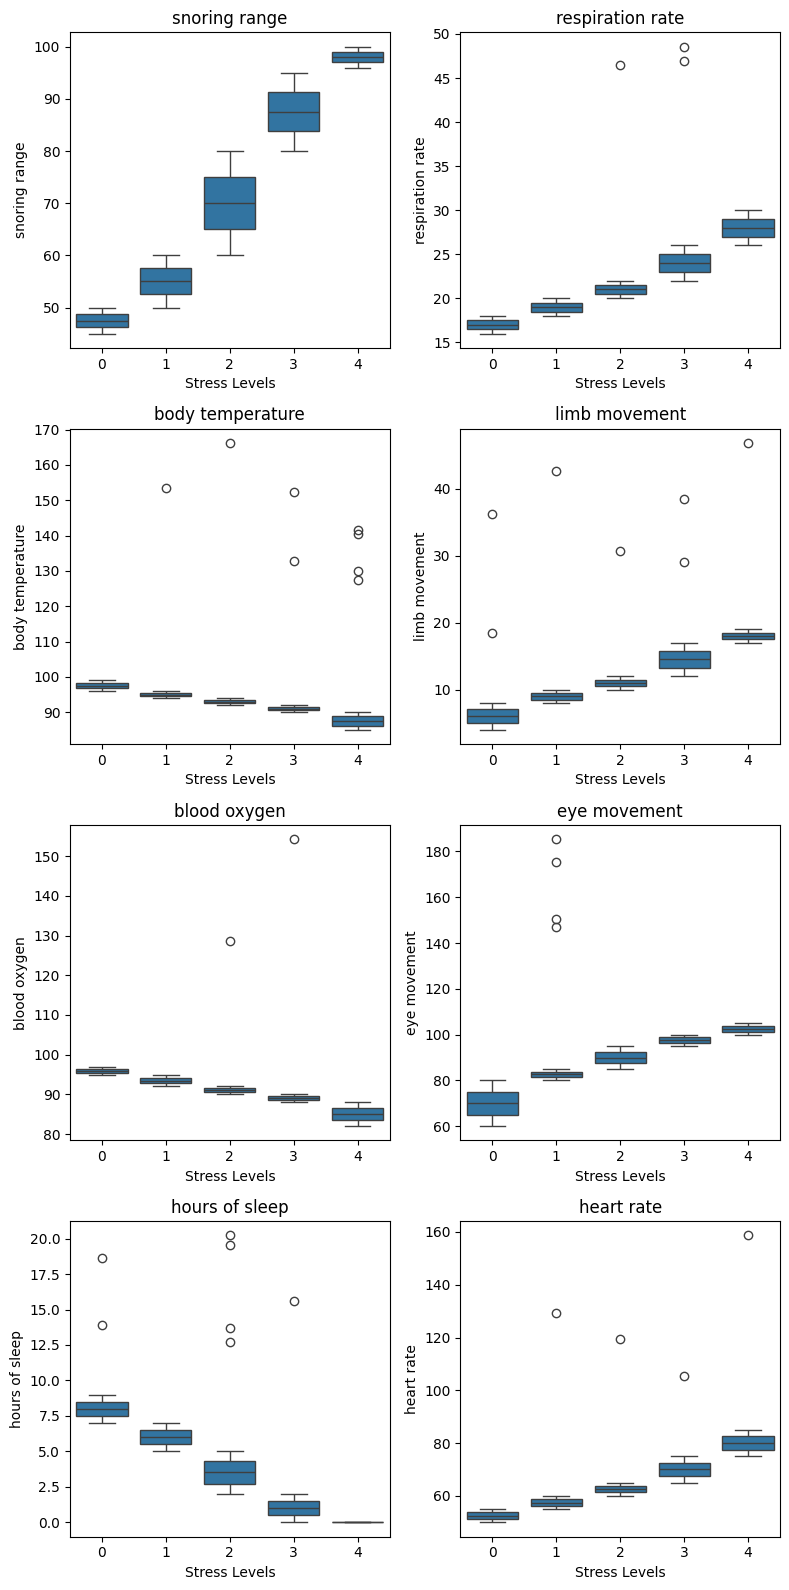

In [9]:
features = stressed_df.columns[0:-1]
plt.figure(figsize=(8,16))
for i, feature in enumerate(features):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x='Stress Levels', y=feature, data=stressed_df)
    plt.title(feature)
plt.tight_layout()
plt.show()

*Для оценки выбросов я построил боксплоты для каждого признака в зависимости от уровня стресса. Здесь мы видим, что выбросы есть для всех признаков, кроме 'snoring range' (громкость храпа). По признакам для которых присутствуют выбросы - примем решение по порядку:*  
**respiration rate** - *мы видим 3 наблюдения, в которых пациенты дышали аномально быстро в сравнении с остальными испытуемыми. Однако нельзя исключать эти случаи, столь частое дыхание может быть вызвано респираторными или хроническими заболеваниями дыхательных путей. Вердикт - окончательное решение принять на этапе выбора модели.*  
**body temperature** - *Нормальная температура человеческого тела — 36.6 °C ±0.7 °C, или 98.2 °F ±1.3 °F, температура 42 °C или же 107,6 °F является опасным для жизни состоянием или гиперпиретической лихорадкой. Крайне маловероятно, что в исследовании принимали участие люди с заболеваниями в острой форме, характеризующимися сильно повышенной температурой тела, поэтому будет разумным считать выбросами значения, выходящие за границы нормальных параметров, а именно 98.2 °F ±1.3 °F. Вердикт - значения, выходящие за обозначенные границы заменить медианой.*  
**limb movement** - *здесь сложно провести однозначную оценку корректности выбросов, при высоком уровне стресса возможны более активные движения во сне. Вердикт - окончательное решение принять на этапе выбора модели.*  
**blood oxygen** - *достоверно известно, что сатурация (процентное содержание насыщенного кислородом гемоглобина в крови) не может превышать 100%. Вердикт - значения, выходящие за обозначенные границы заменить медианой.*  
**eye movement** - *аномально высокое количество движений глаз наблюдается только для уровня стресса 1, поэтому я могу предположить, что это связано с неизвестной нам повторяющейся ошибкой в вычислениях. Так или иначе, наличие таких значений только для одной категории можешь существенно сказаться на точности нашей модели. Вердикт - значения, выходящие за обозначенные границы заменить медианой.*  
**hours of sleep** - *продолжительность сна более 12 часов в сутки рекомендована только для детей в возрасте до 5 лет, к сожалению у нас отсутствуют данные о возрасте испытуемых, но потенциально столь длительный сон возможен. Вердикт - окончательное решение принять на этапе выбора модели.*  
**heart rate** - *мы наблюдаем 4 измерения, которые явно являются аномальными. Нормальным считается пульс в диапазоне 40-50 уд/мин для спящего человека. При нарушении качества сна или заболеваниях сердечно-сосудистой системы пульс может превышать 90 уд/мин во время сна. В общих чертах описанная выше тенденция наблюдается, однако имеющиеся 4 наблюдения с крайне высоким пульсом, которые могут существенно повлиять на точность определения уровня стресса. Вердикт - окончательное решение принять на этапе выбора модели.*

In [10]:
# Теперь, когда мы разобрались с выбросами, сначала обработаем их, а затем перейдем к обработке пропусков
def replace_outliers_median(group):
    q1 = group.quantile(0.25)
    q3 = group.quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    median_v = group.median() # берем медиану для последующей замены
    return np.where((group < lower) | (group > upper), median_v, group)

for col in numeric:
    stressed_df[col] = stressed_df.groupby('Stress Levels', observed=False)[col].transform(replace_outliers_median)

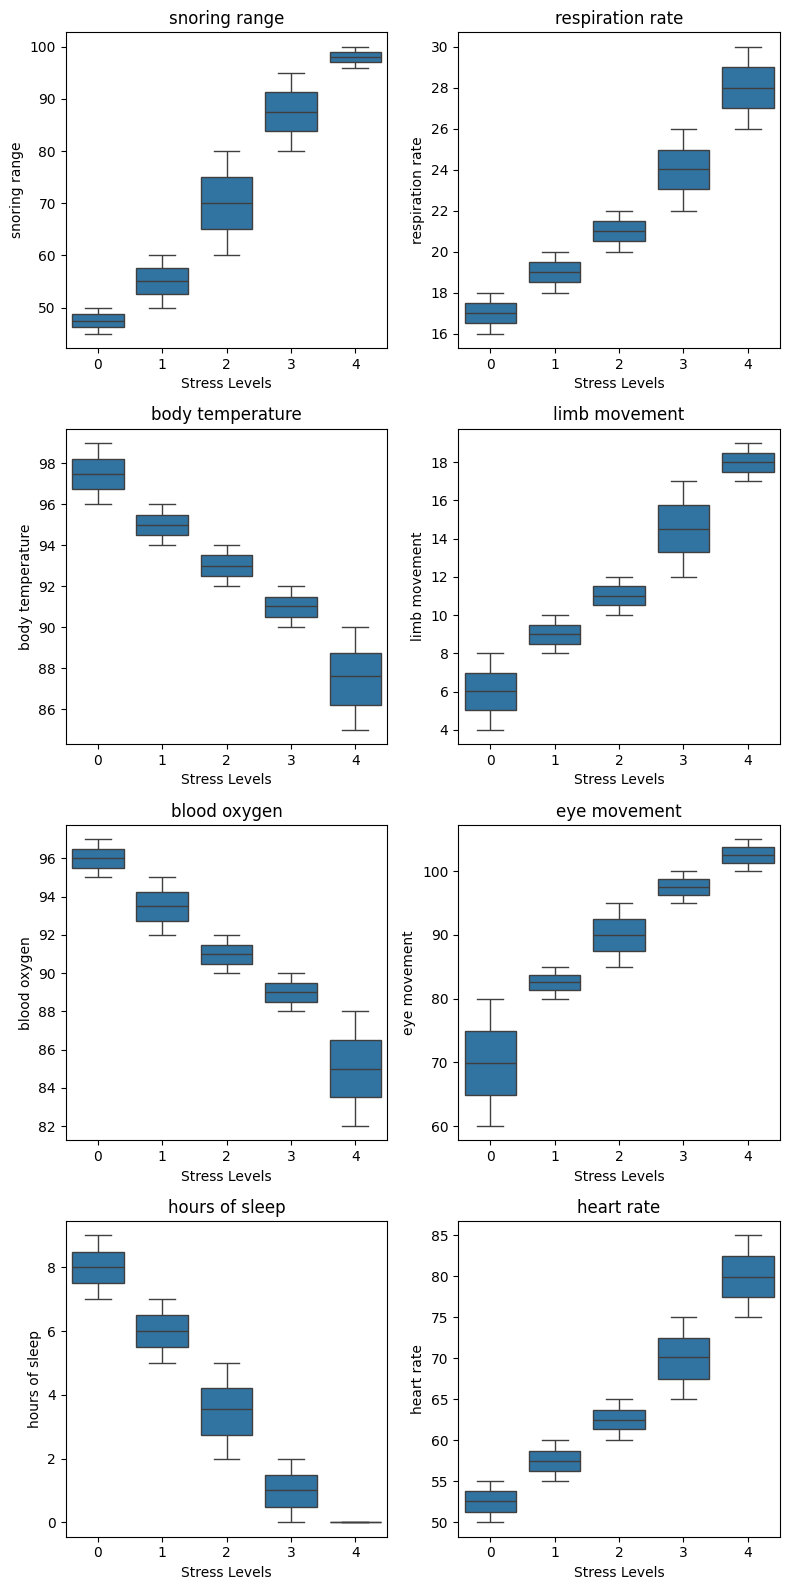

In [11]:
# Проверяем, что у нас получилось
features = stressed_df.columns[0:-1]
plt.figure(figsize=(8,16))
for i, feature in enumerate(features):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x='Stress Levels', y=feature, data=stressed_df)
    plt.title(feature)
plt.tight_layout()
plt.show()

*Теперь, когда мы решили проблему выбросов, мы со спокойной душой можем использовать среднее значение для заполнения пропусков.*

In [12]:
# Выведем описательные статистики перед заменой и после
stressed_df.describe()

,snoring range,respiration rate,body temperature,limb movement,blood oxygen,eye movement,hours of sleep,heart rate
count,630.000000,630.000000,614.000000,618.000000,626.000000,612.000000,619.000000,606.00000
mean,71.600000,21.800648,92.782085,11.681294,90.883463,88.428824,3.701829,64.50066
std,19.372833,3.965369,3.513403,4.295466,3.904615,11.940945,3.059245,9.90401
min,45.000000,16.000000,85.000000,4.000000,82.000000,60.000000,0.000000,50.00000
25%,52.500000,18.500000,90.516000,8.484000,88.484000,81.230000,0.472000,56.21000
50%,70.000000,21.012000,92.976000,11.000000,90.984000,89.760000,3.572000,62.50000
75%,91.250000,24.968000,95.468000,15.710000,94.226000,98.730000,6.512000,72.50000
max,100.000000,30.000000,99.000000,19.000000,97.000000,105.000000,9.000000,85.00000


In [13]:
for col in numeric:
    stressed_df[col] = stressed_df.groupby('Stress Levels', observed=False)[col].transform(lambda x: x.fillna(x.mean()))

In [14]:
stressed_df.describe()

,snoring range,respiration rate,body temperature,limb movement,blood oxygen,eye movement,hours of sleep,heart rate
count,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000
mean,71.600000,21.800648,92.801132,11.704074,90.892877,88.485248,3.699062,64.508110
std,19.372833,3.965369,3.522074,4.289828,3.899618,11.908455,3.052757,9.892435
min,45.000000,16.000000,85.000000,4.000000,82.000000,60.000000,0.000000,50.000000
25%,52.500000,18.500000,90.532000,8.516000,88.500000,81.290000,0.500000,56.250000
50%,70.000000,21.012000,92.994387,11.006439,90.989120,89.996000,3.524000,62.514622
75%,91.250000,24.968000,95.500000,15.710000,94.226000,98.670000,6.500000,72.420000
max,100.000000,30.000000,99.000000,19.000000,97.000000,105.000000,9.000000,85.000000


*Видим, что после замены незначительно изменились такие метрики как среднее и например 25% квантиль для 'body temperature'.*

*Если присмотреться к средним и медианным значениям - мы увидим, что они отличаются незначительно, поэтому я выдвигаю гипотезу, что наше распределение близко к нормальному. На 3-м этапе займусь проверкой данной гипотезы.*

**Восстановление данных**  
*Если присмотреться к графикам, то можно заметить, что для 4-го уровня стресса длительность сна нулевая для всей категории. Нулевые значения в этой категории ошибочны, тк достоверно известно, что исследования проводились во сне, стоит обработать некорректные значения для этой категории. В начале я планировал восстановить длительность сна с помощью регрессионного анализа, но мы имеем не строго линейную зависимость. Разумным решением будет применение градиентного бустинга, реализовать который можно с помощью библиотеки xgboost. Градиентный бустинг является популярным решением для предсказания/восстановления параметров. Также попробую случайный лес, возможно он даст лучший результат и меньшую среднеквадратичную ошибку.*

In [15]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [16]:
# Верну int, чтобы избежать ужаса, то есть ругачки
stressed_df['Stress Levels'] = stressed_df['Stress Levels'].astype('int')

In [17]:
# Отбираем тренировочную выборку с уровнями стресса до 3 включительно
train_slp = stressed_df[stressed_df['Stress Levels'] < 4]
x_train = train_slp.drop(columns=['hours of sleep'])
y_train = train_slp['hours of sleep']

# Честно делим на обучающую и валидационную выборку
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Обучаем модель
model = XGBRegressor(objective='reg:squarederror', max_depth=4, n_estimators=100, learning_rate=0.1)
model.fit(x_train, y_train)

# Оценка модели, средняя квадратичная ошибка
val_pred = model.predict(x_val)
mse = mean_squared_error(y_val, val_pred)
print(f"MSE: {mse}")

# Переходим к восстановлению длительности сна для 4-го уровня стресса
test_slp = stressed_df[stressed_df['Stress Levels'] == 4].drop(columns=['hours of sleep'])
slp_prediction = model.predict(test_slp[0:5])
slp_prediction

MSE: 0.024002691936773006


array([0.6877616, 0.6877616, 0.6877616, 0.6877616, 0.6877616],
      dtype=float32)

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
# Тестирую случайный лес
model2 = RandomForestRegressor(n_estimators=100, random_state=42)
model2.fit(x_train, y_train)

# Оценка модели, средняя квадратичная ошибка
val_pred = model2.predict(x_val)
mse = mean_squared_error(y_val, val_pred)
print(f"MSE: {mse}")

# Переходим к восстановлению длительности сна для 4-го уровня стресса
slp_prediction2 = model2.predict(test_slp[0:5])
slp_prediction2

MSE: 0.028238051861977073


array([0.79281561, 0.79281561, 0.79281561, 0.79281561, 0.79281561])

*Мы получили 2 значения для 4-го уровня стресса, а именно 0.69 часа Градиентным бустингом и 0.79 Случайным лесом. Ввиду отсутствия в обучающей выборке примеров для 4-го уровня стресса, мы получаем лишь одно приблизительное значение. "Дропнуть" всю категорию мы не можем себе позволить по причине того, что мы потеряем целый класс наблюдений - это существенно исказит результаты исследования.*  
*Верным решением в нашей ситуации будет принять полученное значение за медиану и сгенерировать вокруг неё случайное распределение с небольшим диапазоном. В качестве медианы примем среднее между полученными значениями (0.79 + 0.69) / 2 = 0.74, а в качестве стандартного отклонения примем среднее стандартное отклонение рассчитанное по классам с 0-го по 3-й.*

In [20]:
median_v = 0.74 # Завожу переменную для медианы

In [21]:
# Функция для извлечения нужных статистик - позаимствовал у Елены, тк время было ограничено
def get_stats(df):
    # Группируем по 'Stress Levels' и получаем описательные статистики
    stats = df.groupby('Stress Levels').describe().T
    
    # Извлекаем std
    selected_stats = stats.loc[(slice(None), 'std'), :]
    
    # Переименовываем колонки в формат "Stress level 'число'"
    selected_stats.columns = [f"Stress level {col}" for col in selected_stats.columns]
    
    return selected_stats

# Получаем статистики для каждого датасета
stats = get_stats(stressed_df)
stats

,,Stress level 0,Stress level 1,Stress level 2,Stress level 3,Stress level 4
snoring range,std,1.460685,2.921370,5.842739,4.382054,1.168548
respiration rate,std,0.584274,0.584274,0.584265,1.150748,1.168548
body temperature,std,0.859126,0.584008,0.582434,0.563076,1.447324
limb movement,std,1.149201,0.574944,0.578057,1.423428,0.579020
blood oxygen,std,0.582936,0.866657,0.573932,0.577440,1.752822
eye movement,std,5.812690,1.421305,2.853780,1.428810,1.443486
hours of sleep,std,0.570809,0.582734,0.854304,0.576932,0.000000
heart rate,std,1.440631,1.447960,1.376873,2.870136,2.860917


In [22]:
# Рассчитываем стандартное отклонение
std_v = sum(stats.loc['hours of sleep'].loc['std'].reset_index()['std'].to_list()) / 4
print(f"Рассчитали среднее стандартное отклонение для длительности сна {round(std_v, 2)}.")

Рассчитали среднее стандартное отклонение для длительности сна 0.65.


*Далее необходимо озаботиться заданием границ для усеченного справа и слева нормального распределения. Слева минимальным значением будет 0.083, что соответсвует 5 минутам (минимальная продолжительность короткого сна). Усечение справа определим как макимальное значение для 3-го уровня стресса, тк это не противоречит наблюдаемым на графиках зависимостям между 'hours of sleep' и 'Stress Levels'. Над способом рассчета пороговых значений и распределения работали совместно с Еленой.*

In [23]:
lower_bond = 0.083 # создаю переменную для нижней границы

In [24]:
# Берем уровни храпа из 4-й категории стресса и ищем минимальное значение для поиска совпадения в 3-й категории
tier4_zero_slp = stressed_df[(stressed_df['Stress Levels'] == 4) & (stressed_df['hours of sleep'] == 0)]
tier4_snor_min = tier4_zero_slp['snoring range'].unique().min()
print(f"Минимальная громкость храпа для 4-й категории: {tier4_snor_min}")

# Ищем совпадения в 3-й категории и смотрим длительность сна
tier3_snor = stressed_df[(stressed_df['Stress Levels'] == 3)]['snoring range'].max()
print(f"Максимальная громкость храпа для 3-й категории: {tier3_snor}")

# Смотрим длительность сна, для найденно строки и принимаем как верхнее пороговое значение
upper_bond = stressed_df[(stressed_df['Stress Levels'] == 3) & (stressed_df['snoring range'] == tier3_snor)]['hours of sleep'].iloc[0]
print(f"Верхнюю границу для распределения принимаем: {upper_bond}")

Минимальная громкость храпа для 4-й категории: 96.0
Максимальная громкость храпа для 3-й категории: 95.0
Верхнюю границу для распределения принимаем: 2.0


*Теперь, когда у нас есть границы для усеченного нормального распределения, сгенерируем данные для длительности сна, и заполним ими пропуски, отталкиваясь от громкости храпа.*

Сгенерированное среднее: 0.8353, медиана: 0.7428, std: 0.5192


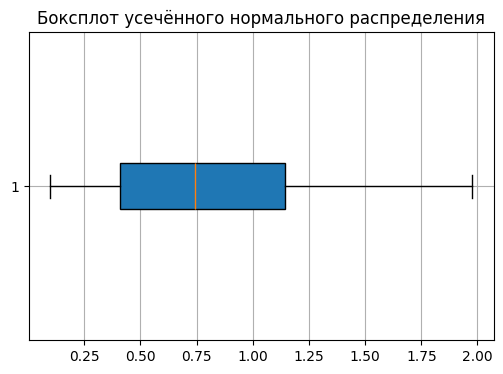

In [25]:
from scipy.stats import truncnorm

tol = 1e-5  # Точность
mu_guess = median_v  # Начальное приближение, приблизительно берем mu_guess = median_v (то есть 0.74)
diff = 1  

# Из-за усечения распределение не симметрично, и его медиана смещается, поэтому нужно скорректировать μ:
while abs(diff) > tol: # Вычисляем текущую медиану trunc_median на основе mu_guess
    trunc_median = truncnorm.median( 
        (lower_bond - mu_guess) / std_v, (upper_bond - mu_guess) / std_v, loc=mu_guess, scale=std_v
    )
    diff = median_v - trunc_median # Если она отличается от median_v, двигаем mu_guess в нужную сторону
    mu_guess += diff * 0.1  # Двигаем `μ` в нужную сторону

mu_corrected = mu_guess

# Генерация распределения
a, b = (lower_bond - mu_corrected) / std_v, (upper_bond - mu_corrected) / std_v
samples = truncnorm.rvs(a, b, loc=mu_corrected, scale=std_v, size=126)

# Статистики
print(f"Сгенерированное среднее: {np.mean(samples):.4f}, медиана: {np.median(samples):.4f}, std: {np.std(samples):.4f}")

# Боксплот
plt.figure(figsize=(6, 4))
plt.boxplot(samples, vert=False, patch_artist=True)
plt.title("Боксплот усечённого нормального распределения")
plt.grid()
plt.show()

In [26]:
# Сортируем полученные значения, чтобы записывать по ворзрастанию грокости храпа
hours_of_sleep = sorted(samples, reverse=True)

# Отделим 0-3 уровень стресса и 4-й, в 4-м заменим значения  в поле 'hours of sleep' полученным распределением.
tier_4 = stressed_df[stressed_df['Stress Levels'] == 4].sort_values(by='snoring range')
tier_0_3 = stressed_df[stressed_df['Stress Levels'] < 4]
tier_4['hours of sleep'] = hours_of_sleep
stressed_df = pd.concat([tier_0_3, tier_4])
stressed_df[stressed_df['Stress Levels'] == 4].head(5)

,snoring range,respiration rate,body temperature,limb movement,blood oxygen,eye movement,hours of sleep,heart rate,Stress Levels
79,96.000,26.000,85.00,17.000,82.000,100.00,1.977642,75.00,4
321,96.032,26.032,85.04,17.016,82.048,100.04,1.937234,75.08,4
323,96.064,26.064,85.08,17.032,82.096,100.08,1.935395,75.16,4
153,96.096,26.096,85.12,17.048,82.144,100.12,1.934613,75.24,4
501,96.128,26.128,85.16,17.064,82.192,100.16,1.926639,75.32,4


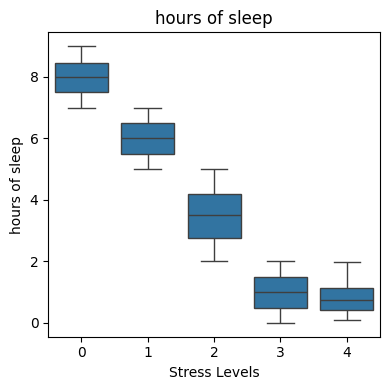

In [27]:
# Проверяем, что у нас получилось
feature = stressed_df.columns[-3]
plt.figure(figsize=(4, 4))
sns.boxplot(x='Stress Levels', y=feature, data=stressed_df)
plt.title(feature)
plt.tight_layout()
plt.show()

*Теперь часы сна для 4-й категории ненулевые, то есть нам удалось восстановить целостность данных.*

**3 Описаельные статистики по переменным**

In [28]:
# Настройка параметров отображения для вывода всех строк
pd.set_option('display.max_rows', None)
# Выведем описательные статистики по переменным с группировкой по уровням стресса
stressed_df.groupby('Stress Levels').describe().T

Stress Levels                    0           1           2           3  \
snoring range    count  126.000000  126.000000  126.000000  126.000000   
                 mean    47.500000   55.000000   70.000000   87.500000   
                 std      1.460685    2.921370    5.842739    4.382054   
                 min     45.000000   50.000000   60.000000   80.000000   
                 25%     46.250000   52.500000   65.000000   83.750000   
                 50%     47.500000   55.000000   70.000000   87.500000   
                 75%     48.750000   57.500000   75.000000   91.250000   
                 max     50.000000   60.000000   80.000000   95.000000   
respiration rate count  126.000000  126.000000  126.000000  126.000000   
                 mean    17.000000   19.000000   21.000444   24.002794   
                 std      0.584274    0.584274    0.584265    1.150748   
                 min     16.000000   18.000000   20.000000   22.000000   
                 25%     16.500000   18.500000   20.500000   23.032000   
                 50%     17.000000   19.000000   21.012000   24.024000   
                 75%     17.500000   19.500000   21.500000   24.968000   
                 max     18.000000   20.000000   22.000000   26.000000   
body temperature count  126.000000  126.000000  126.000000  126.000000   
                 mean    97.496400   94.998774   92.994387   91.005528   
                 std      0.859126    0.584008    0.582434    0.563076   
                 min     96.000000   94.000000   92.000000   90.000000   
                 25%     96.780000   94.500000   92.500000   90.532000   
                 50%     97.496400   94.998774   92.994387   91.006764   
                 75%     98.202000   95.500000   93.500000   91.468000   
                 max     99.000000   96.000000   94.000000   92.000000   
limb movement    count  126.000000  126.000000  126.000000  126.000000   
                 mean     6.014976    9.004323   11.004878   14.499512   
                 std      1.149201    0.574944    0.578057    1.423428   
                 min      4.000000    8.000000   10.000000   12.000000   
                 25%      5.064000    8.516000   10.516000   13.330000   
                 50%      6.032000    9.006161   11.006439   14.499512   
                 75%      6.968000    9.484000   11.484000   15.710000   
                 max      8.000000   10.000000   12.000000   17.000000   
blood oxygen     count  126.000000  126.000000  126.000000  126.000000   
                 mean    95.996480   93.488384   90.986240   88.993280   
                 std      0.582936    0.866657    0.573932    0.577440   
                 min     95.000000   92.000000   90.000000   88.000000   
                 25%     95.500000   92.750000   90.500000   88.500000   
                 50%     95.994240   93.488192   90.989120   89.000640   
                 75%     96.500000   94.226000   91.468000   89.484000   
                 max     97.000000   95.000000   92.000000   90.000000   
eye movement     count  126.000000  126.000000  126.000000  126.000000   
                 mean    69.943415   82.479680   89.996000   97.479339   
                 std      5.812690    1.421305    2.853780    1.428810   
                 min     60.000000   80.000000   85.000000   95.000000   
                 25%     65.000000   81.290000   87.660000   96.290000   
                 50%     69.943415   82.540000   89.996000   97.479339   
                 75%     74.840000   83.670000   92.420000   98.670000   
                 max     80.000000   85.000000   95.000000  100.000000   
hours of sleep   count  126.000000  126.000000  126.000000  126.000000   
                 mean     7.997419    6.003776    3.496262    0.997854   
                 std      0.570809    0.582734    0.854304    0.576932   
                 min      7.000000    5.000000    2.000000    0.000000   
                 25%      7.516000    5.500000    2.750000    0.500000   
    

**4 Изучаем признаки и принимаемые ими значения**

In [29]:
our_signs = {'number': 'Количественные', 'category': 'Категориальные'}
for s, n in our_signs.items():
    print(f"Рассмотрим {n} признаки:")
    if s == 'number':
        for v in numeric:
            print(f"{v} принимает значения в диапазоне: {stressed_df[v].min()} - {stressed_df[v].max()};")
    elif s == 'category':
        for v in categorical:
            print(f"{v} может принимать уникальные значения: {stressed_df[v].unique()};")

Рассмотрим Количественные признаки:
snoring range принимает значения в диапазоне: 45.0 - 100.0;
respiration rate принимает значения в диапазоне: 16.0 - 30.0;
body temperature принимает значения в диапазоне: 85.0 - 99.0;
limb movement принимает значения в диапазоне: 4.0 - 19.0;
blood oxygen принимает значения в диапазоне: 82.0 - 97.0;
eye movement принимает значения в диапазоне: 60.0 - 105.0;
hours of sleep принимает значения в диапазоне: 0.0 - 9.0;
heart rate принимает значения в диапазоне: 50.0 - 85.0;
Рассмотрим Категориальные признаки:
Stress Levels может принимать уникальные значения: [3 1 0 2 4];


**5 Корреляционная матрица**

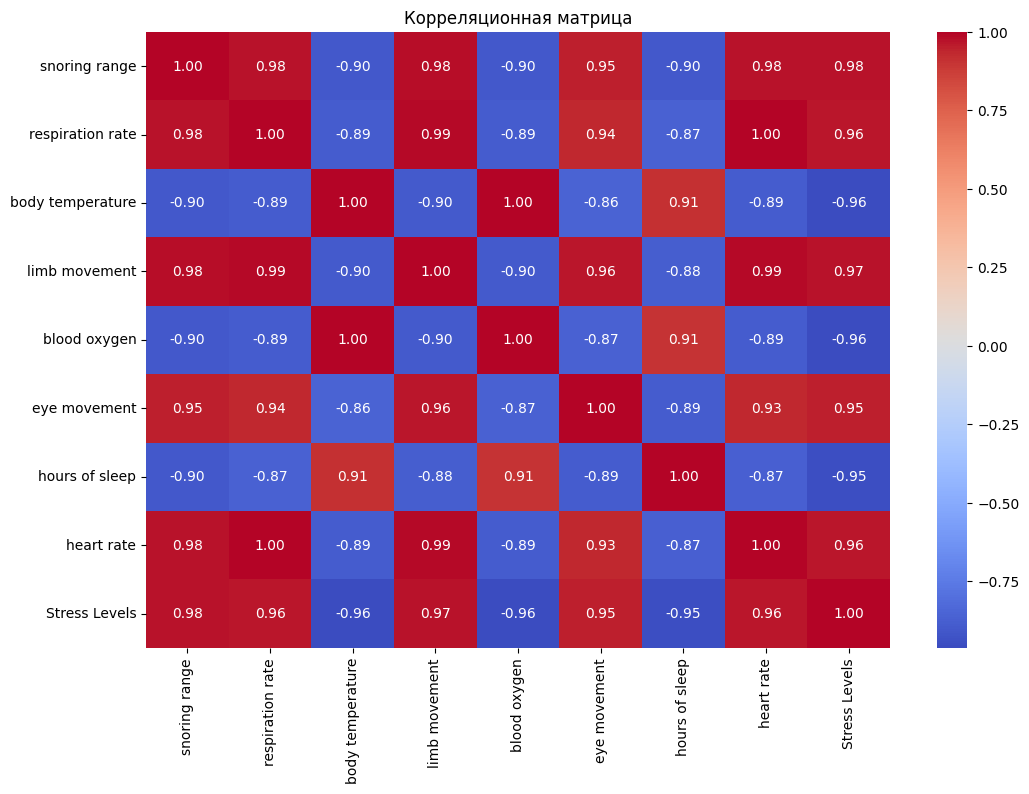

In [30]:
plt.figure(figsize=(12,8))
corr_matrix = stressed_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Корреляционная матрица')
plt.show()

**Важный вывод:**
*Вот прям сразу можем проследить корреляцию например между движением конечностей и пульсом, уровнем стресса и храпом, длительностью сна и сатурацией (вообще это параметр, который действительно очень влияет на качество сна, именно поэтому мы так хорошо спим в загородном доме вблизи леса). Чисто с медицинской точки зрения, матрица выглядит очень реалистично.

**6 Визуализация данных**

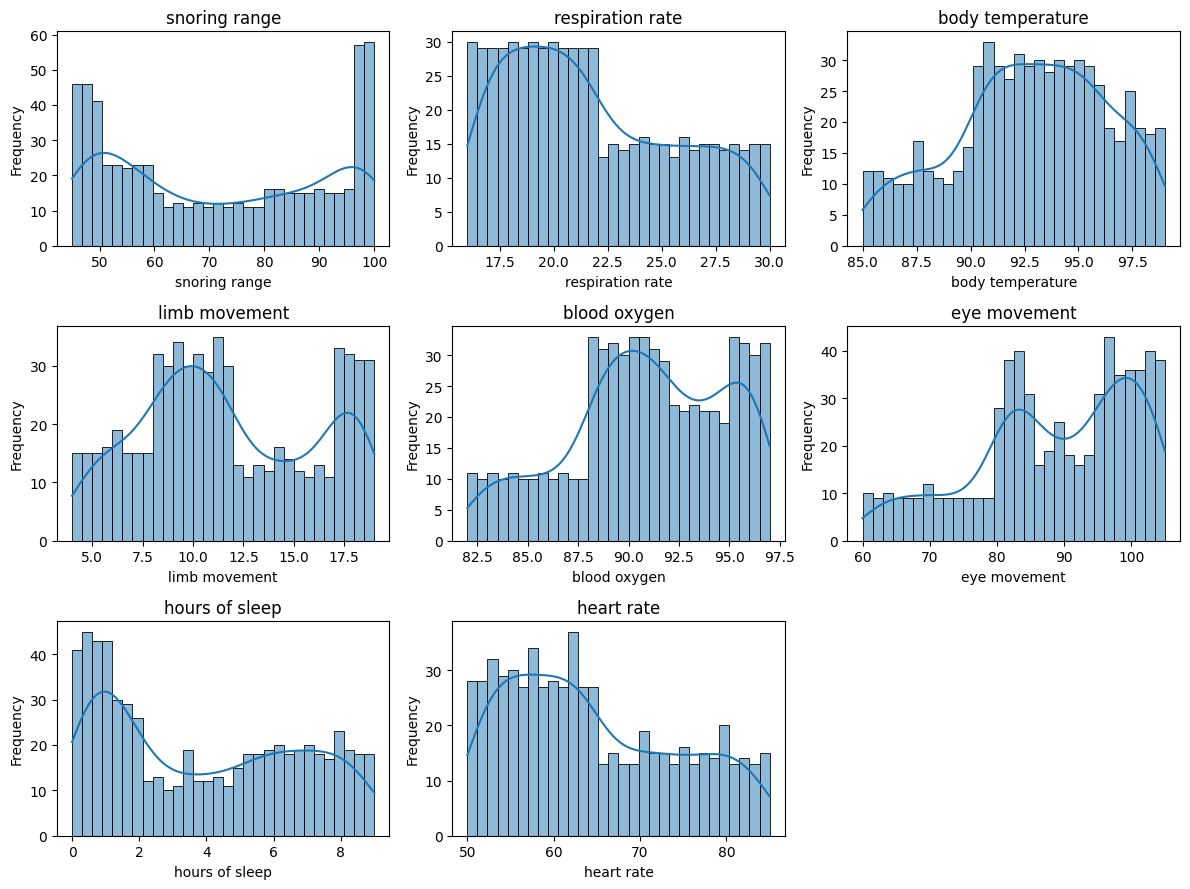

In [31]:
# Гистограммы распределения числовых показателей
plt.figure(figsize=(12, 9))
for i, col in enumerate(numeric, 1):
    plt.subplot(3, 3, i)
    sns.histplot(stressed_df[col], bins=30, kde=True)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

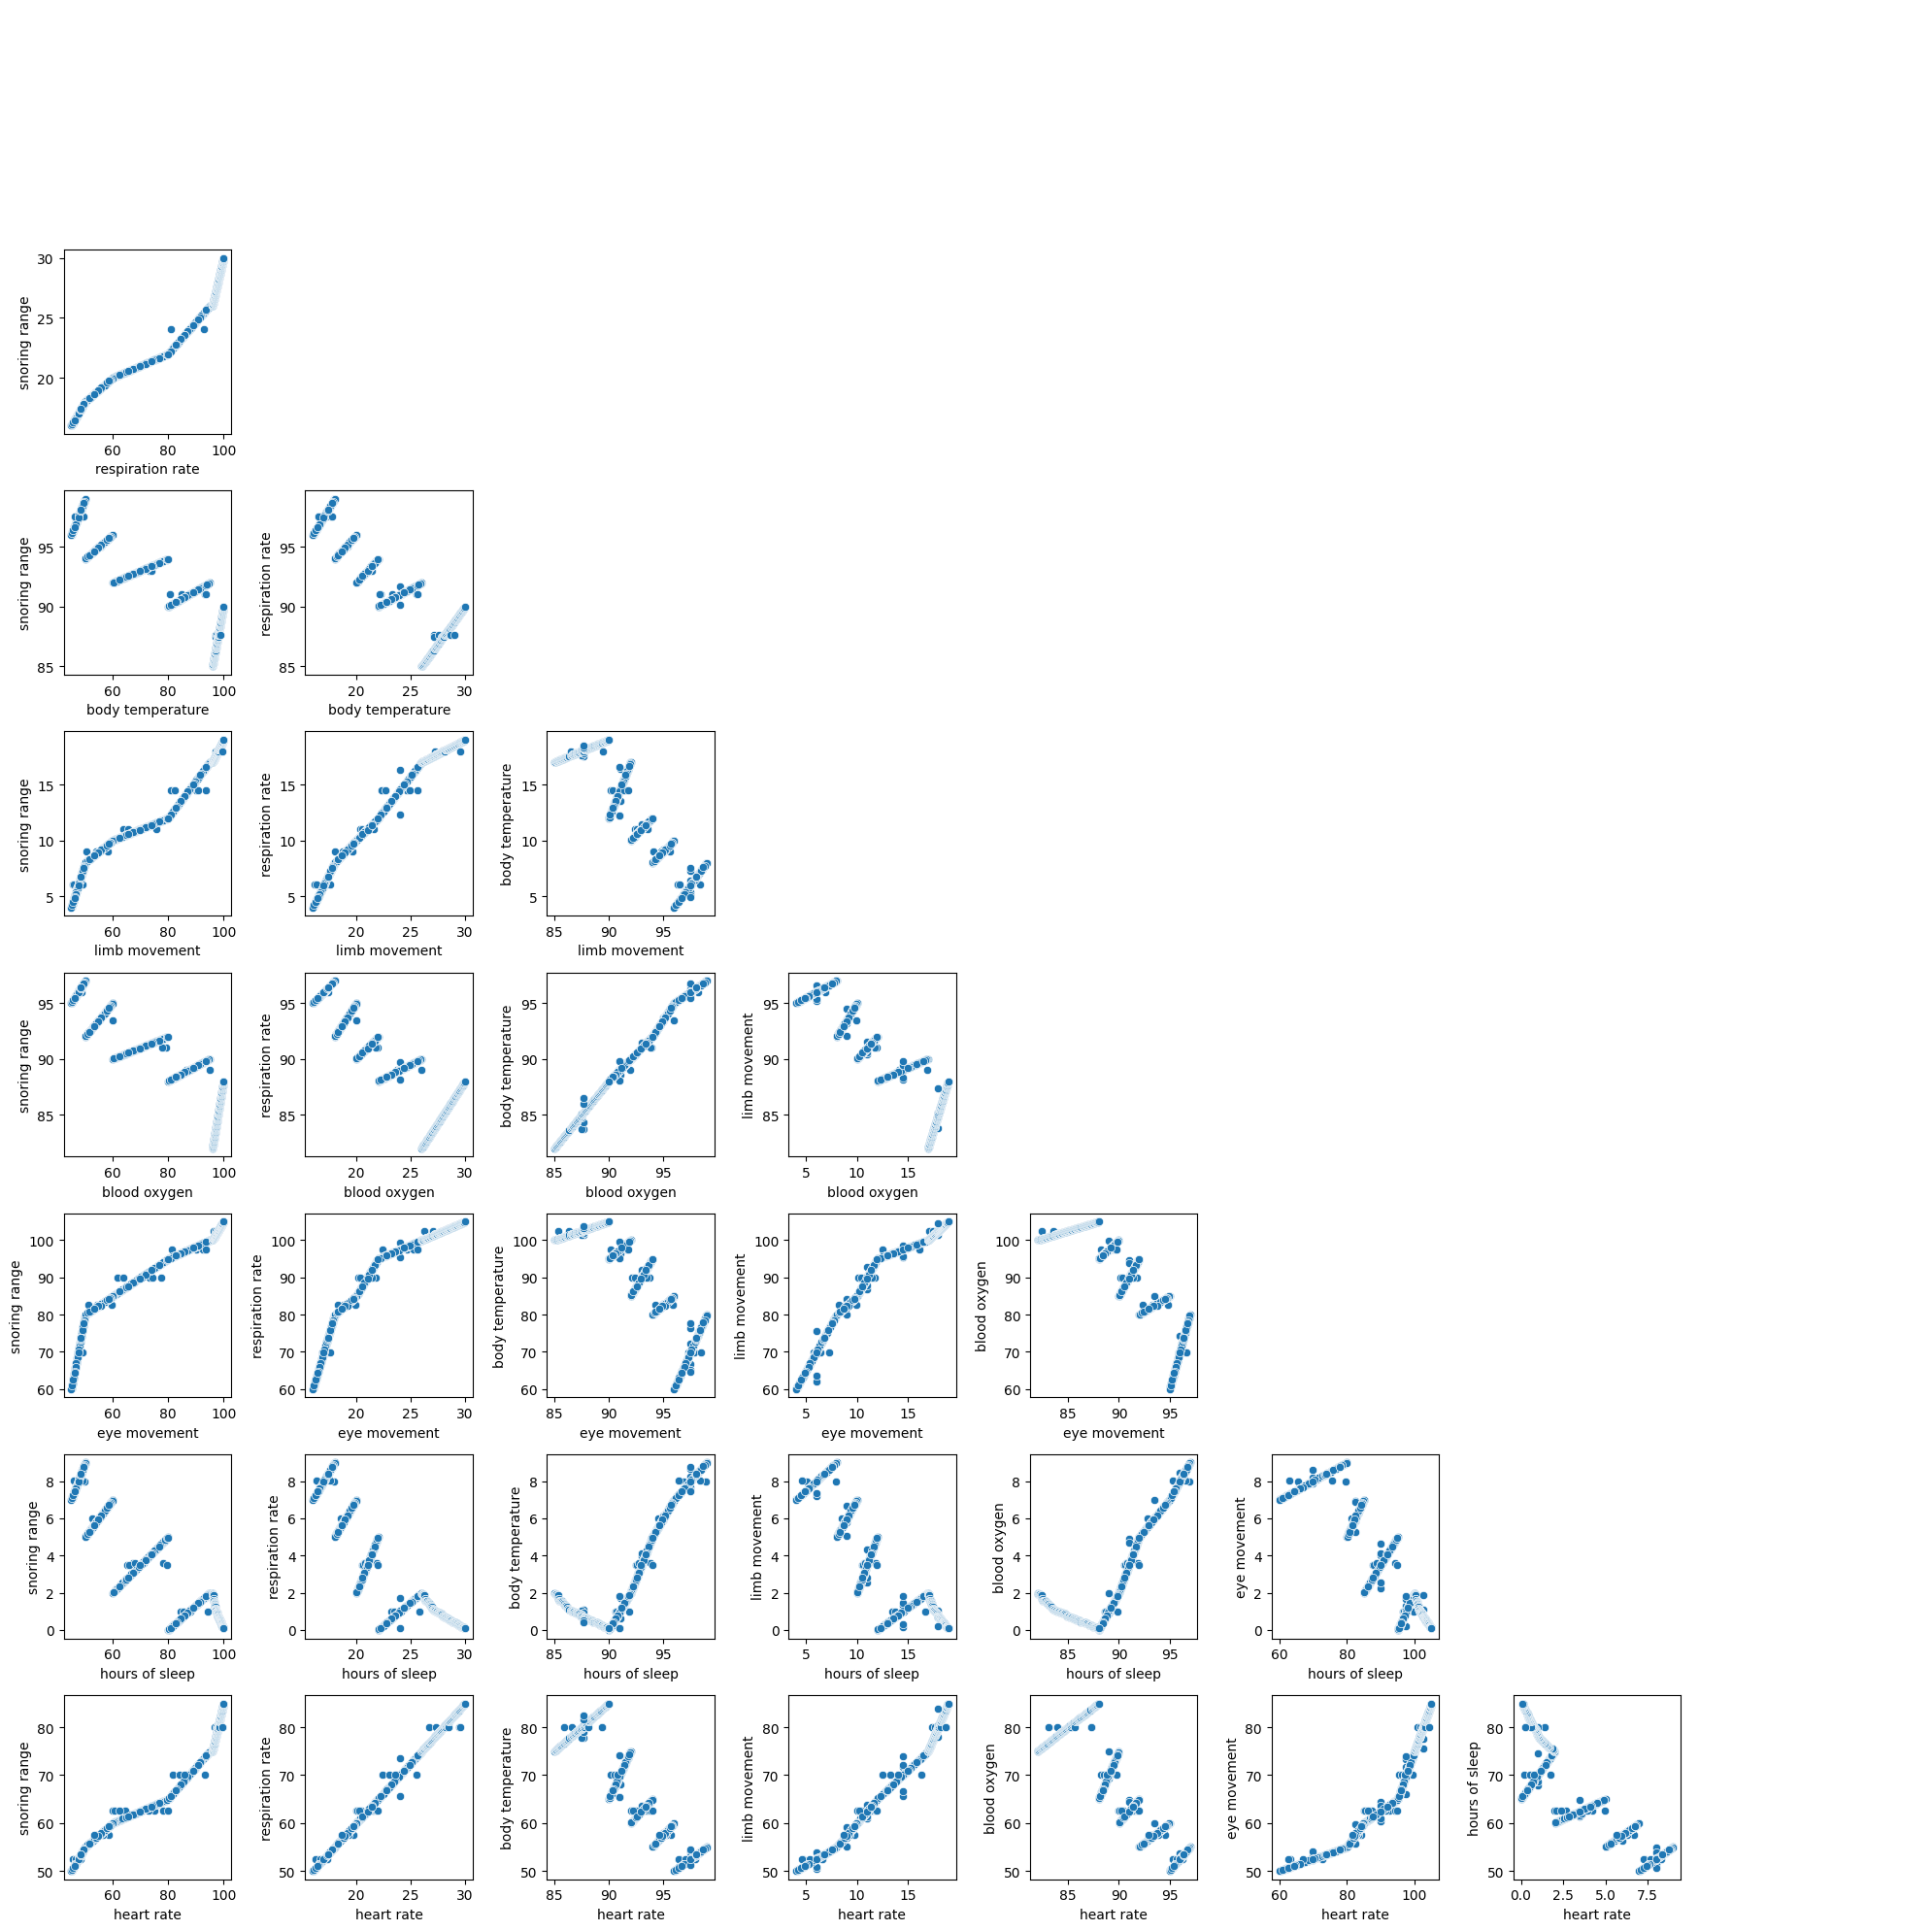

In [32]:
# Вариант без извращений для попарных связей
#plt.figure(figsize=(12, 8))
#sns.pairplot(stressed_df[numeric], corner=True) # corner отрезает все, что выше диагонали
#plt.show()

# Вариант с извращением
plt.figure(figsize=(20, 20))
num_cols = len(numeric)
for i in range(num_cols):
    for j in range(num_cols):
        if i > j:
            plt.subplot(num_cols, num_cols, i * num_cols + j + 1)
            sns.scatterplot(data=stressed_df, x=numeric[j], y=numeric[i])
            plt.xlabel(numeric[i])
            plt.ylabel(numeric[j])
        else:
            plt.subplot(num_cols, num_cols, i * num_cols + j + 1).axis('off')

plt.tight_layout()
plt.show()

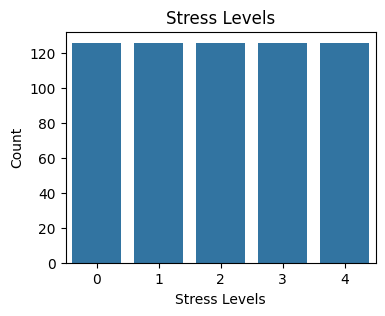

In [33]:
# Пусть у нас всего 1 категориальная переменная, но и для неё постоим, хехе
plt.figure(figsize=(4, 3))
sns.countplot(data=stressed_df, x=categorical[0])
plt.title(f'{categorical[0]}')
plt.xlabel(categorical[0])
plt.ylabel('Count')
plt.show()

*PS у нас по 126 измерений для каждого уровня стресса.*

**Выводы**  
*Исходя из увиденного можно заключить:*  
*- наблюдается четкая связь между повышением уровня стресса и снижением продолжительности сна;
- с повышением уровня стресса усиливается храп, повышается частота сердечных сокращений и дыхания;
- процент пропусков для всех полей датафрейма не превышает 4%, пропуски были заполнены средними для каждой группы по уровню стресса;
- выбросы были обработаны с помощью метода IQR, а также разобраны логически, с упором в медицинскую практику;*

**Гипотезы для дальнейшего исследования**  
*1 Распределением большинства признаков близко к нормальному;*  
*2 Низкое качество сна может быть как следствием, так и причиной увеличения уровня стресса;*  
*3 Вероятно существование различных типов реакций на стресс (например, разные изменения пульса, храпа или температуры), что можно проверить с помощью кластерного анализа;*  